In [2]:
# dependencies

import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import seaborn as sns
from textblob import TextBlob
import matplotlib.pyplot as plt

## Getting Started
1. Load dependencies
2. Load data [here we use CSV]

In [9]:
# load the data
DATA_SOURCE = "my_library.csv"
data = pd.read_csv(DATA_SOURCE, memory_map=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551 entries, 0 to 550
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   item ID (Read-Only)   551 non-null    object 
 1   original ID           40 non-null     object 
 2   type                  551 non-null    object 
 3   created (Read-Only)   551 non-null    object 
 4   updated (Read-Only)   551 non-null    object 
 5   read                  551 non-null    bool   
 6   notes                 23 non-null     object 
 7   color                 74 non-null     object 
 8   flag                  551 non-null    bool   
 9   ratings               0 non-null      float64
 10  doi                   532 non-null    object 
 11  patent_id             0 non-null      float64
 12  pmid                  504 non-null    float64
 13  pmcid                 198 non-null    object 
 14  arxiv                 1 non-null      float64
 15  file (Read-Only)      4

### Problem 1
Some articles do not have an abstract

In [6]:
data["abstract"]

0                                                    NaN
1                                                    NaN
2                                                    NaN
3                                                    NaN
4                                                    NaN
                             ...                        
546    Drug hunters are moving into the clinic with h...
547    Human ALS/FTD patient iPSC-derived neurons are...
548    Developments in computational omics technologi...
549    With an ever-increasing amount of (meta)genomi...
550    We have used pulse-chase labeling of Chinese h...
Name: abstract, Length: 551, dtype: object

## Clean up
Cleanup the data. For this demo we will only be using the title and abstract

In [10]:
import gc
df = data[['title','abstract']]
del data
gc.collect()

df.dropna(inplace=True)
df.drop_duplicates(subset=['abstract'],inplace=True)

/Users/uri/Desktop/Projects/JCARLO/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until


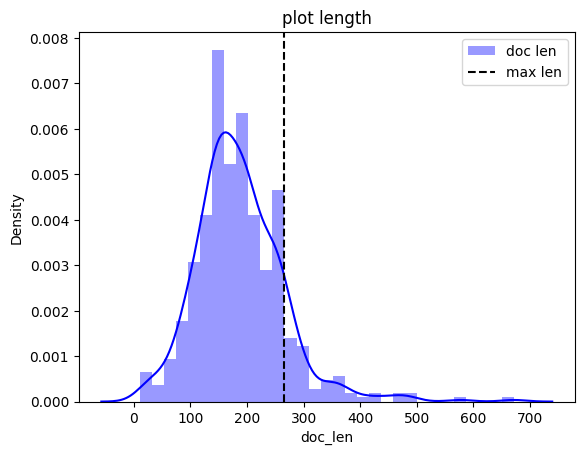

In [14]:
df['doc_len'] = df['abstract'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

## Chose a Model
This is probably one of the most critical steps: chose a good model that represents the task at hand. First we he to consider between:
1. Symmetric search
2. Asymmetric search

Because we want to search through a pool of large passages we will chose assymetric search. There are plenty of models in this group which are also tunes for different types of searches: euclidian distance, dot-plot, cosine-similiarity.

**Disclosure**: I dont' understand the difference between search approaches so I will be using a trivial dot-plot search approach.

**Todo**: Investigate the type of similarities (cosine, dot-plot, euclidian distance)

In [2]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('msmarco-distilbert-base-v4')

In [16]:
from tqdm.auto import tqdm
tqdm.pandas()

def get_embeddings(documents):
    sentences  = [documents]
    sentence_embeddings = model.encode(sentences)
    encod_np_array = np.array(sentence_embeddings)
    encod_list = encod_np_array.tolist()
    return encod_list[0]

In [17]:
df['vector'] = df['abstract'].progress_apply(get_embeddings)

  0%|          | 0/502 [00:00<?, ?it/s]

## Start ElasticSearch server
There are alternatives to using the elasticsearch server. But for convenience and the purposes of this demo I'll be using a local elasticsearch server.

We go ahead and start the server and establishing the connection.

In [4]:
from elasticsearch import Elasticsearch

es = Elasticsearch(
    "https://localhost:9200/",
    basic_auth=("elastic", "Z1*nfDFd1YhmgLg8w1qo"),
    ca_certs="/Users/uri/Desktop/Dev/elasticsearch-8.10.4/config/certs/http_ca.crt"
)

es.ping()

True

## Creating an index mapping for elasticsearch



```
index_mapping = {
    "properties": {
        "title": {
            "type": "text"
        },
        "abstract": {
            "type": "text"
        },
        "doc_len": {
            "type": "long"
        },
        "vector": {
            "type": "dense_vector",
            "dims": 768,
            "index": True,
            "similarity": "cosine"
        }
    }
}
```

In [22]:
from indeces_elastic.mapping_msmarco_distilbert_base_v4 import index_mapping

es.indices.create(index="papers", mappings=index_mapping)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'papers'})

## Store data in ElasticSearch

After creating the mapping we can the store our data in the server

In [23]:
elk_data = df.to_dict("records")

for record in elk_data:
    try:
        es.index(index="papers", document=record)
    except Exception as e:
        print(e)

In [24]:
es.count(index="papers")

ObjectApiResponse({'count': 502, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}})

## Setup is Complete

Now we just need to setup the search query and extract the results

In [5]:
input_kw = "FDX1 is directly targeted by Elesclomol"
input_embedding = model.encode(input_kw)

query = {
    "field": "vector",
    "query_vector": input_embedding,
    "k": 5,
    "num_candidates": 500
}

res = es.knn_search(index="papers", knn=query, source=["title", "abstract"])
res["hits"]['hits']

print(res)

reference = [target['_source']  for target in res['hits']['hits']] 

for ref in reference:
    print("Title:", ref['title'])
    print("\n")


{'took': 13, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 500, 'relation': 'eq'}, 'max_score': 0.75682986, 'hits': [{'_index': 'papers', '_id': 'ZU7FcYsBJooCoyqGiANk', '_score': 0.75682986, '_source': {'title': 'Elesclomol induces cancer cell apoptosis through oxidative stress', 'abstract': 'Elesclomol (formerly STA-4783) is a novel small molecule undergoing clinical evaluation in a pivotal phase III melanoma trial (SYMMETRY). In a phase II randomized, double-blinded, controlled, multi-center trial in 81 patients with stage IV metastatic melanoma, treatment with elesclomol plus paclitaxel showed a statistically significant doubling of progression-free survival time compared with treatment with paclitaxel alone. Although elesclomol displays significant therapeutic activity in the clinic, the mechanism underlying its anticancer activity has not been defined previously. Here, we show that elesclomol induces apoptosis 

/Users/uri/Desktop/Projects/JCARLO/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: ElasticsearchWarning: The kNN search API has been replaced by the `knn` option in the search API.
  # This is added back by InteractiveShellApp.init_path()


### Improvements
1. Launch the ElasticSearch server from Docker